In [11]:
import site
print(site.getsitepackages())

['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages']


In [12]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

from bokeh.io import curdoc, show
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, TextInput, DateRangeSlider, HelpButton, Tooltip, DataTable, WheelZoomTool
from bokeh.models import NumberFormatter, TableColumn, RadioGroup, Button, CustomJS, SetValue, Div, ColorPicker, Spacer
from bokeh.plotting import figure
from bokeh.models.dom import HTML
from bokeh.themes import Theme
from bokeh.palettes import Spectral6
from bokeh.settings import settings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor


#CONSTANTS
MAX_WIDTH_SLIDERS=600
BACKGROUND_C= "#fefefe"
BORDER_C= "#F7F0DE"   #"white" #   "#F0F0AA"
CONFIG_ROW_C = "#FFF"
BLUE_C= "#125779"
LIGHT_BROWN = "#B7AB87"
LIGHT_GREY="#BFB8A7"
DATASET_LENGTH=90
MAIN_FIG_HEIGHT=320
MIN_WIDTH=400
MODEL_OPTIONS=["SARIMAX", "RF_REGR", "1D-CNN", "XGBOOST"]

settings.default_server_port = 5007

'''SYNTHETIC DATA GENERATION0.03
INCLUDING: {
seasonal_component: amplitude, frequency, shift
trend_component: slope, quadratic_curvature, CUBIC_CURVATURE
noise: standard normal distributed with mean=0, sd=1
AUTOCORELLATION : 
}
'''


# -----------------------------------------------TIME SERIES GENERATOR FUNDAMENTALS---------------------------------- #

def generate_seasonal_component(t, amplitude, frequency, shift):
    return amplitude * np.sin(2 * np.pi * frequency * t + shift* np.pi)

def generate_trend_component(t, slope, curvature_quadratic, curvature_cubic):
    return slope * t + curvature_quadratic * t**2 + curvature_cubic * t**3

def generate_autoregressive_component(t, ar_coefficients):
    ar_data = np.zeros_like(t)
    for i in range(len(ar_coefficients)):
        if i == 0:
            continue
        ar_data[i] = np.sum(ar_data[:i] * ar_coefficients[:i]) + np.random.randn()    
    return ar_data

def generate_noise(noise_level):
    return np.round(noise_level * np.random.randn(len(t)),4)

def generate_synthetic_time_series(t, amplitude, frequency, slope, shift, offset,
                                   curvature_quadratic, curvature_cubic, ar_coefficients=None):
    seasonal_component = generate_seasonal_component(t, amplitude, frequency, shift)
    trend_component = generate_trend_component(t, slope, curvature_quadratic, curvature_cubic)
    
    if ar_coefficients is not None:
        ar_data = generate_autoregressive_component(t, ar_coefficients)
    else:
        ar_data = np.zeros_like(t)

    synthetic_data_ = offset + seasonal_component + trend_component + ar_data
    return np.round(synthetic_data_, 4)

# SET INITIAL PARAMETERS   
t = np.linspace(0, 30, 90)
amplitude = 2.0               
shift = 0
offset = 0
frequency = 0.1                 
slope = 0.1
curvature_quadratic = 0.0
curvature_cubic = 0
noise_level = 0.5
ar_coefficients = None
#amplitude, or frequency could have irregularities to.

# CREATE INITIAL TIME SERIES
synthetic_data = generate_synthetic_time_series(t, amplitude, frequency, slope, shift, offset, curvature_quadratic,
                                                 curvature_cubic, ar_coefficients=None)
default_noise = generate_noise(noise_level)

synthetic_data = pd.Series(synthetic_data + default_noise)
synthetic_data.round(decimals=4)



#-----------------------------------------------BASIC BOKEH IMPLEMENTATION-------------------------------------------#

plot = figure(min_width=MIN_WIDTH, max_width=1800, height=MAIN_FIG_HEIGHT, width_policy="max", title="Synthetic time series",
              tools="pan,reset,save, xwheel_zoom", margin=(0, 0, -1, 0), background_fill_color=BACKGROUND_C, min_border=30,
              border_fill_color=BORDER_C, styles={"padding-righ":"300", "border-right":"300px"}, min_border_right=60,
              min_border_left=70, x_range=[0, 89], y_range=[-7, 25], align="center")


source = ColumnDataSource(data=dict(time=synthetic_data.index, synthetic_data=synthetic_data.values))
synth_data_line=plot.line('time', 'synthetic_data', source=source, line_width=2.5, line_alpha=0.8,  legend_label="synthetic_data")
plot.legend.location = "top_left"
plot.legend.background_fill_alpha = 0.8
plot.xaxis.axis_label = "time"
plot.yaxis.axis_label = "value"
plot.toolbar.active_scroll = plot.select_one(WheelZoomTool)


text = TextInput(title="title", value='Synthetic Time Series fancy')
slope = Slider(title="slope", value=0.2, start=-1.0, end=1.3, step=0.05, align="center")
amplitude = Slider(title="amplitude", value=2.0, start=-5.0, end=7.0, step=0.25, align="center")
phase = Slider(title="phase", value=0.0, start=0.0, end=2, step=0.5, align="center")
freq = Slider(title="frequency", value=0.1, start=0.02, end=0.3, step=0.02, align="center")
noise = Slider(title="noise", value=0.5, start=0.0, end=2.5, step=0.05, align="center")
offset = Slider(title="offset", value=0.0, start=-5.0, end=5.0, step=0.05, align="center")
date_range_slider = DateRangeSlider(value=(date(2018, 9, 15), date(2020, 9, 15)), step=10, start=date(2016, 9, 1),
                                    end=date(2022, 4, 15), margin=(0, 30, 0, 30), align="center")
train_test_split_slider = Slider(title="train_test_split", value=60, start=45, end=80, step=1, align="center")
line_thickness = Slider(title="line_thickness", value=2.5, start=1.0, end=3.5, step=0.05, align="center")
#Components such as row() and column() elements share their sizing mode with all of their children that do not have their own explicit sizing mode.



# -----------------------------------------------CALLBACK IMPLEMENTATION--------------------------------------------#
def update_title(attrname, old, new):
    plot.title.text = text.value

def update_data(attrname, old, new):

    # Get the current slider values
    a = amplitude.value
    o_ = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, o_, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ default_noise)
    synthetic_data_temp.round(decimals=4)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)

def update_noise(attrname, old, new):
    global default_noise

    n = noise.value
    updated_noise = generate_noise(n)
    default_noise=updated_noise
    
    a = amplitude.value
    o_ = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, o_, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ updated_noise)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)
    
text.on_change('value', update_title)
noise.on_change("value", update_noise)
for widget_ in [offset,slope, amplitude, phase, freq]:
    widget_.on_change('value', update_data)


# -------------------------------------MODEL IMPLEMENTATION & BOKEH TRANSFORMATION------------------------------------#
# Data Preparation & Train-Test Split

y_train_CDS = ColumnDataSource({"time":[], "value": []})
y_test_CDS = ColumnDataSource({"time":[],"value":[]})
y_pred_CDS = ColumnDataSource({"time": [],"lower_y": [], "upper_y": [],"predictions":[]})
y_pred_second_CDS = ColumnDataSource({"time": [],"lower_y": [], "upper_y": [],"predictions":[]})

plot_2 = figure(min_width=MIN_WIDTH, max_width=1800, height=MAIN_FIG_HEIGHT, width_policy="max", title="Synthetic time series prediction",
              tools="pan,reset,save,xwheel_zoom", margin=(-1, 0, 0, 0), background_fill_color=BACKGROUND_C, border_fill_color=BORDER_C,
               min_border_left=70, min_border_right=60, x_range=plot.x_range, y_range=[-7, 25], align="center")
train_data_glyph=plot_2.line('time', 'value', source=y_train_CDS, line_width=2.5, line_alpha=0.8, legend_label="train_data")
test_data_glyph=plot_2.line('time', 'value', source=y_test_CDS, line_width=2.5, line_alpha=0.7, line_color="#2ca02c", legend_label="test_data",
                            muted_color="#2ca02c", muted_alpha=0.2)
pred_data_glyph=plot_2.line('time', 'predictions', source=y_pred_CDS, line_width=2.5, line_alpha=0.9, line_color="#ff7f0e", line_dash="dashdot",
                             legend_label="model_prediction_M1", muted_color="#ff7f0e", muted_alpha=0.2)
pred_data_second_glyph=plot_2.line('time', 'predictions', source=y_pred_second_CDS, line_width=2.5, line_alpha=0.8, line_color="#982764",
                             line_dash="dashdot", legend_label="model_prediction_M2", muted_color="#982764", muted_alpha=0.2)
plot_2.legend.location = "top_left"
plot_2.legend.background_fill_alpha = 0.8
plot_2.legend.click_policy="mute"
plot_2.xaxis.axis_label = "time"
plot_2.yaxis.axis_label = "value"
plot_2.toolbar.active_scroll = plot_2.select_one(WheelZoomTool)



# Include own modules and functions
from dataframe_lagger import time_series_lagger, train_test_split, walk_forward_validation_historic


def create_model(train_df, test_df, model_selection, input_laggs=6):
    assert model_selection in MODEL_OPTIONS, f"'{model_selection}' is not a valid choise. Please choose from {MODEL_OPTIONS}."

    if model_selection == "SARIMAX":
        ARMAmodel_ = ARIMA(train_df["values"], order = (2, 2, 2))    #ARIMA(p, d, q) -> pdq account for seasonality, trend, and noise in data
        SARIMAXmodel_ = SARIMAX(train_df["values"], order = (1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
        current_model = SARIMAXmodel_.fit()
        print(current_model.summary().tables[1])
        y_pred = current_model.get_forecast(len(test_df.index))
        y_pred_df = y_pred.conf_int(alpha = 0.05) 
        y_pred_df["Predictions"] = current_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = test_df["time"]
        print(y_pred_df)
        y_pred_out = y_pred_df["Predictions"] 
        #current_model.plot_diagnostics(figsize=(16, 8))

    elif model_selection =="RF_REGR":
        data_concatenated = pd.concat([train_df, test_df.iloc[1:,:]], ignore_index=True)
        tsl = time_series_lagger(data_concatenated.loc[:,"values"].to_list(), n_in=input_laggs, n_out=1, dropnan=True)           
        print(tsl)
        current_model, mae, y, y_pred = walk_forward_validation_historic(tsl, test_df.shape[0], model_selection="RF")
        y_pred_df = pd.DataFrame(data={"Predictions":y_pred, "lower values":y_pred, "upper values":y_pred})
        y_pred_df.index = test_df["time"]
        print(y_pred_df)
        ##TODO very much --> not so much anymore


    elif model_selection=="1D-CNN":
        data_concatenated = pd.concat([train_df, test_df.iloc[1:,:]], ignore_index=True)
        scaler = MinMaxScaler()
        values_scaled = scaler.fit_transform(data_concatenated)
        tsl = time_series_lagger(data_concatenated.loc[:,"values"].to_list(), n_in=input_laggs, n_out=1, dropnan=True)       
        #tsl = time_series_lagger(values_scaled, n_in=6, n_out=1, dropnan=True)
        print("tsl_cnn:")
        print(tsl)
        current_model, mae, y, y_pred = walk_forward_validation_historic(tsl, test_df.shape[0], model_selection="CNN")
        y_pred_df = pd.DataFrame(data={"Predictions":y_pred, "lower values":y_pred, "upper values":y_pred})
        y_pred_df.index = test_df["time"]
        print("Mean_Absolute_Error_CNN: "+ str(mae))


    elif model_selection=="XGBOOST":
        data_concatenated = pd.concat([train_df, test_df.iloc[1:,:]], ignore_index=True)
        tsl = time_series_lagger(data_concatenated.loc[:,"values"].to_list(), n_in=input_laggs, n_out=1, dropnan=True)
        print(tsl)
        current_model, mae, y, y_pred = walk_forward_validation_historic(tsl, test_df.shape[0], model_selection="XGB")
        y_pred_df = pd.DataFrame(data={"Predictions":y_pred, "lower values":y_pred, "upper values":y_pred})
        y_pred_df.index = test_df["time"]
        print(y_pred_df)


    return current_model, y_pred_df


def update_model_(split_ind=60, model_selection="SARIMAX", model_selection_2=None):
    model_selection_index = radio_group_models.active
    model_selection_second_index = radio_group_models2.active
    model_selection = model_selection_dict[model_selection_index]
    print(model_selection)
    if train_test_split_slider.value is not None:
        split_ind=train_test_split_slider.value
    train_df = pd.DataFrame(data={"time": source.data["time"][0:split_ind+1], "values": source.data["synthetic_data"][0:split_ind+1]})   
    test_df = pd.DataFrame(data={"time": source.data["time"][split_ind:], "values": source.data["synthetic_data"][split_ind:]})
    
    ####---> GO INTO MODEL FUNC, RETURN:(train_df, test_df, pred_df)
    current_model, pred_df = create_model(train_df=train_df, test_df=test_df, model_selection=model_selection, input_laggs=10)
    if model_selection_second_index is not None:
        model_selection_2 = model_selection_dict[model_selection_second_index]
        print(model_selection_2)
        current_model_2, pred_df_2 = create_model(train_df=train_df, test_df=test_df, model_selection=model_selection_2)
        y_pred_second_CDS.data = ({"time": pred_df_2.index,
                        "lower_y": pred_df_2.loc[:,"lower values"].values,
                        "upper_y": pred_df_2.loc[:,"upper values"].values,
                        "predictions": pred_df_2.loc[:,"Predictions"].values})
    else:
        print("\n\n!-----------model_selection_2 is currently not set.-----------------!\n\n\n\n")

    y_train_CDS.data = ({"time": train_df["time"],
                        "value": train_df["values"]})
    y_test_CDS.data = ({"time": test_df["time"],
                        "value": test_df["values"]})
    y_pred_CDS.data = ({"time": pred_df.index,
                        "lower_y": pred_df.loc[:,"lower values"].values,
                        "upper_y": pred_df.loc[:,"upper values"].values,
                        "predictions": pred_df.loc[:,"Predictions"].values})
    

# DEV_STUFF
# split_ind=60
# from dataframe_lagger import time_series_lagger
# train_df = pd.DataFrame(data={"time": source.data["time"][0:split_ind], "values": source.data["synthetic_data"][0:split_ind]})   
# test_df = pd.DataFrame(data={"time": source.data["time"][split_ind-1:], "values": source.data["synthetic_data"][split_ind-1:]})
# current_model, pred_df = create_model(train_df=train_df, test_df=test_df, model_selection="SARIMAX")
# result = time_series_lagger(data=train_df["values"].to_list(), n_in=5, n_out=1, dropnan=True)



# -----------------------------------------------USER EXPLANATION (HTML)----------------------------------------------#
help_slope = HelpButton(tooltip=Tooltip(content=HTML("""
the slope represents the general trend of the time series.<br /> It determines the <b>average increase</b>
in y over a period of time.<br/>More information: <a href="https://en.wikipedia.org/wiki/Slope">slope</a>!
"""), position="right"), align="center")


# Read the custom CSS from an external file
with open('custom_styles.css', 'r') as css_file:
    custom_css = css_file.read()

# Create a Div to hold the custom CSS
#css_div = Div(text=custom_css)
css_div = Div(text=f"<style>{custom_css}</style>")


C = Div(text="C", width=40, styles={'font-size': "1.5rem","font-weight":"400"},margin=(0, 40, 0, 0))
#O = Div(text=f"{custom_css}<h1>O</h1>", width=40)
O = Div(text="O", width=40, styles={'font-size': "1.5rem","font-weight":"400"},margin=(0, 40, 0, 0))
N = Div(text="N", width=40, styles={'font-size': "1.5rem","font-weight":"400"},margin=(0, 60, 0,0))
F = Div(text="F", width=40, styles={'font-size': "1.5rem","font-weight":"400"},margin=(0, 40, 0, 0))
I = Div(text="I", width=40, styles={'font-size': "1.5rem","font-weight":"400"},margin=(0, 40, 0, 4))
G = Div(text="G", width=40, styles={'font-size': "1.5rem","font-weight":"400"},margin=(0, 40, 0, 0))
model1_text = Div(text="M1", styles={"font-size": "2rem", "font-weight":"300"}, align="center")
model2_text = Div(text="M2", styles={"font-size": "2rem", "font-weight":"300"}, align="center")



# Load the custom template
with open('custom_template.html', 'r') as file:
    template = file.read()




# -----------------------------------------------DATA TABLE IMPLEMENTATION--------------------------------------------#
columns = [
        TableColumn(field="time", title="time"),
        TableColumn(field="synthetic_data", title="value", formatter=NumberFormatter(format="0.0000")),
    ]

data_table = DataTable(source=source, columns=columns, height=230, editable=True, align="center", margin=(0,40,0,65), sizing_mode="stretch_width")


# -----------------------------------------------CURRENT_DOC REFRESHMENT--------------------------------------------#
button = Button(label="Apply Model", button_type="success", align="center")
button2 = Button(label="Reset Model", button_type="success", align="center")
button2.js_on_event("button_click", SetValue(button, "label", "Apply Model"))

button.on_click(update_model_)
button.js_on_event("button_click", CustomJS(code="console.log('button: click!', this.toString())"))
button.js_on_event("button_click", SetValue(button, "label", "Model applied"))
      
     
for widget_ in [offset,slope, amplitude, phase, freq]:
    widget_.on_change('value', update_data)  
    #widget_.js_on_change("value", SetValue(button, "label", "Apply Model"))  


for line_ in [synth_data_line, train_data_glyph, test_data_glyph, pred_data_glyph]:
    line_thickness.js_link(attr='value', other=line_.glyph, other_attr='line_width')                 

radio_group_models = RadioGroup(labels=MODEL_OPTIONS, active=None, align="center")
radio_group_models2= RadioGroup(labels=MODEL_OPTIONS, active=None, align="center")
model_selection_dict = {key:value for (key,value) in zip(range(4), MODEL_OPTIONS)}

def radio_handler(attrname, old, new):
    print('Radio button option ' + str(new) + ' selected.')

radio_group_models.js_on_event('button_click', CustomJS(code="""
    console.log('radio_group: active=' + this.origin.active, this.toString())
"""))
radio_group_models.on_change("active", radio_handler)
radio_group_models2.on_change("active", radio_handler)
#radio_group_models.js_on_change("change:active", SetValue(button, "label", "Apply XY"))
#radio_group_models.on_event("button_click", radio_handler)

button2.js_on_event("button_click", SetValue(button, "label", radio_group_models.active))

picker = ColorPicker(title="BG_Color_Core")
#picker.js_link('color', line.glyph, 'line_color')


# -----------------------------------------------FINALIZE LAYOUT CURRENT_DOC--------------------------------------------#


# bokeh serve --show Synth_data_app_003.py
# bokeh serve Synth_data_app_003.py --dev                        <---DEV-mode
# http://localhost:5006/Synth_data_app

curdoc().title = "Synthetic data"
slope_with_annot= row(slope, help_slope, align="center")
amplitude_with_annot = row(amplitude, help_slope, align="center")
phase_with_annot = row(phase, help_slope, align="center")
freq_with_annot = row(freq, help_slope, align="center")
noise_with_annot = row(noise, help_slope, align="center")

space=Spacer(height=300, sizing_mode="stretch_width")
space_2=Spacer(width=2)
config_col = column(C, O, N, F, I, G, width=40, align="center", styles={"border-radius": "5px", "margin-right":"40px"})
config_col_2 = column(C, O, N, F, I, G, width=40, align="center", styles={"margin-left":"50px", "margin-right":"-20px"}) 
slider_menu_layout = column(slope_with_annot, amplitude, offset, freq, noise, sizing_mode="stretch_width")
slider_menu_layout_annot = column(slope_with_annot, amplitude_with_annot, phase_with_annot, freq_with_annot,
                                   noise_with_annot, sizing_mode="stretch_width")
button_row = row(button, button2, align="center")
model_first_selection_row = row(model1_text,radio_group_models, styles={"background-color":"rgba(255,127,14,0.8)", "border-radius":"6px"}, align="center") 
model_second_selection_row = row(model2_text, radio_group_models2, styles={"background-color":"rgba(152,39,100,0.8)", "border-radius":"6px"}, align="center")
model_selection_row= row(model_first_selection_row, space_2, model_second_selection_row, align="center")
model_selection_interface = column(model_selection_row, train_test_split_slider, button_row, line_thickness, sizing_mode="stretch_width", align="center")
core_row_layout = row(config_col, slider_menu_layout, data_table, model_selection_interface, config_col_2 , align="center", margin=0,
                      styles={'font-size': "1.5rem","background-color": "#F4F4F4", "border-radius":"15px", "padding": "10px 10px 10px 10px",
                                "border-style":"solid", "border-width":"2.0px"}, sizing_mode="stretch_width")
core_row_layout_border = row(core_row_layout, styles={"background-color": BORDER_C, "padding":"8px 100px 8px 100px"},
                              sizing_mode="stretch_width", align="center")
bottom_row = row(date_range_slider, styles={"background_color": BORDER_C}, align="center") # sizing_mode is incompatible with alignment centered
final_layout = column(plot, core_row_layout_border, plot_2, sizing_mode="stretch_width")

#EEEAE9

model_selection_interface.styles["background-color"] ="ff7f0e"
cd = curdoc()
#cd.template = template
cd.add_root(final_layout)
cd.theme = Theme(filename="theme.yaml") #improving the modularity of the app and decouple the style layer from the view layer
cd.add_root(css_div)


print(core_row_layout.styles["background-color"])



##TODO
### Data Generation
#   |--- ADD length of data ? (Current instances: 90)
#   |--- CHANGE to datetime objects ?
#   |--- Apply Feature: Ground_level/Offset                              √ DONE
#   |--- Apply Feature: Quadratic/Cubic Slope + Corresponding Widget    

### Data Visualization
#    |--- Customizable Autocorrelation Plot (User should choose the lags) (one or span of multiple)
#    |--- distribution of data change

### Forecast Model implementation 
#   |--- 1. State of the Art Deterministic Forecast: (SARMIAX)           √ DONE
#   |--- 2. ML-based: Random Forest                                      - IN PROGRESS 
#   |--- 3. ML-based: XGB Boost                                         
#   |--- 4. Sophisticated ML-model: (CNN), (LSTM)                        - IN PROGRESS

### Fine Tuning
#    |--- 1.Interactive Legends (Muting)

#comment 1

#F4F4F4


In [14]:
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error



def time_series_lagger(data, n_in=1, n_out=1, dropnan=True):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		pandas df: dimensionality LEN_DATA x (N_IN + N_OUT) initial:(90x(5+1))
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ... t-1, t0)
	for i in range(n_in-1, -1, -1):
		cols.append(df.shift(i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(1, n_out+1):
		cols.append(df.shift(-i))
		names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
		
	return agg

def train_test_split(data, test_set_len):
	return data[:-test_set_len, :], data[-test_set_len:, :]



def random_forest_initial(train):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:5]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	current_model = RandomForestRegressor(n_estimators=300)
	current_model.fit(trainX, trainy)
	return current_model


def walk_forward_validation_historic(data, test_set_len):
	prediction_list = list()
	train_data, test_data = train_test_split(data.values, test_set_len) #receives np.array (df.values) 90x5 -> returns df 60x5, 30x5
	print(data.shape)
	print(train_data.shape)
	print(test_data.shape)
	current_model = random_forest_initial(train_data)
	for i in range(len(test_data)):
		testX, testy = test_data[i, :-1], test_data[i, -1]      #--> 1x5; 1x1 from 30x5, 30x1
		y_pred= current_model.predict([testX])
		prediction_list.append(y_pred[0])	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred[0]))

	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return error, test_data[:, -1], prediction_list



#-----#
#-----#
#-------------------------------------------------------------------------FOLLOWING FUNCTIONS IN DEVELOPMENT-------------------------#
#-----#
#-----#
def random_forest_forecast(train, testX):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:5]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	model = RandomForestRegressor(n_estimators=300)
	model.fit(trainX, trainy)
	# make a one-step prediction
	#print("real value: {}".format(train))
	y_pred = model.predict([testX])
	return y_pred[0]


def walk_forward_validation_online(data, test_set_len):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		test_set_len: Number of test set observations
	Returns:
		error: 
		test_label: returns the test labels (real values) for the test sequence via 
		prediction_array: returns all prediction via python list
	"""
	prediction_list = list()
	train_data, test_data = train_test_split(data, test_set_len)
	history = [x for x in train_data]     #--> initial: 60x6 
	for i in range(len(test_data)):		  #--> initial: 30x6	
		testX, testy = test_data[i, :-1], test_data[i, -1]     #--> 1x5; 1x1 from 30x5, 30x1
		y_pred = random_forest_forecast(history, testX)		   #--> fit rf on history, evaluate on test instance		
		prediction_list.append(y_pred)						   #--> build y_pred array	
		history.append(test_data[i])						   #--> append to history	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred))
		# estimate prediction error
	print(test_data[:, -1])
	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return error, test_data[:, -1], prediction_list
#-------------------------------------------------------------------------FUNCTIONS ABOVE IN DEVELOPMENT-------------------------#

In [15]:
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten



def time_series_lagger(data, n_in=1, n_out=1, dropnan=True):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		pandas df: dimensionality LEN_DATA x (N_IN + N_OUT) initial:(90x(5+1))
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ... t-1, t0)
	for i in range(n_in-1, -1, -1):
		cols.append(df.shift(i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(1, n_out+1):
		cols.append(df.shift(-i))
		names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
		
	return agg

def train_test_split(data, test_set_len):
	return data[:-test_set_len, :], data[-test_set_len:, :]



def random_forest_initial(train):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:10]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	current_model = RandomForestRegressor(n_estimators=100, random_state=42)
	current_model.fit(trainX, trainy)
	return current_model

def xgboost_initial(train):
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:10]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	current_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	current_model.fit(trainX, trainy)
	return current_model

def cnn_initial(train):
    train_ = np.asarray(train)
    X_train, y_train = train_[:, :-1], train_[:, -1]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    window_size = X_train.shape[1]
    current_model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])

    current_model.compile(optimizer='adam', loss='mse')
    current_model.fit(X_train, y_train, epochs=200, verbose=0)
    return current_model



def walk_forward_validation_historic(data, test_set_len, model_selection, input_laggs=6):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		test_set_len: Number of test set observations
		model_selection: String from ["RF","XGB","CNN"]
		input_laggs: Number of input laggs from data
	Returns:
		current_model:
		error: 
		test_label: returns the test labels (real values) for the test sequence via 
		prediction_array: returns all prediction via python list
	"""
	prediction_list = list()
	train_data, test_data = train_test_split(data.values, test_set_len) #receives np.array (df.values) 90x5 -> returns df 60x5, 30x5
	print("-.-\n-.-.-\ndata_shape:     "+ str(data.shape))
	print("train_data_shape: " + str(train_data.shape))
	print("test_data_shape: "+ str(test_data.shape) + "\n-.-.-\n-.-")
	if model_selection=="RF":
		current_model = random_forest_initial(train_data)
	elif model_selection=="XGB":
		current_model = xgboost_initial(train_data)
	elif model_selection=="CNN":
		current_model = cnn_initial(train_data)
		print("SUCCESS CNN")
	
	for i in range(len(test_data)):
		testX, testy = test_data[i, :-1], test_data[i, -1]      #--> 1x5; 1x1 from 30x5, 30x1
		if model_selection=="CNN":
			testX = testX.reshape((1, input_laggs, 1))
			y_pred=current_model.predict(testX)
		else:
			y_pred= current_model.predict([testX])
		prediction_list.append(y_pred[0])	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred[0]))

	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return current_model, error, test_data[:, -1], prediction_list



#-----#
#-----#
#-------------------------------------------------------------------------FOLLOWING FUNCTIONS IN DEVELOPMENT-------------------------#
#-----#
#-----#
def random_forest_forecast(train, testX):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:5]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	model = RandomForestRegressor(n_estimators=300)
	model.fit(trainX, trainy)
	# make a one-step prediction
	#print("real value: {}".format(train))
	y_pred = model.predict([testX])
	return y_pred[0]


def walk_forward_validation_online(data, test_set_len):

	prediction_list = list()
	train_data, test_data = train_test_split(data, test_set_len)
	history = [x for x in train_data]     #--> initial: 60x6 
	for i in range(len(test_data)):		  #--> initial: 30x6	
		testX, testy = test_data[i, :-1], test_data[i, -1]     #--> 1x5; 1x1 from 30x5, 30x1
		y_pred = random_forest_forecast(history, testX)		   #--> fit rf on history, evaluate on test instance		
		prediction_list.append(y_pred)						   #--> build y_pred array	
		history.append(test_data[i])						   #--> append to history	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred))
		# estimate prediction error
	print(test_data[:, -1])
	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return error, test_data[:, -1], prediction_list
#-------------------------------------------------------------------------FUNCTIONS ABOVE IN DEVELOPMENT-------------------------#

In [16]:
split_ind=60
train_df = pd.DataFrame(data={"time": source.data["time"][0:split_ind], "values": source.data["synthetic_data"][0:split_ind]})   
test_df = pd.DataFrame(data={"time": source.data["time"][split_ind-1:], "values": source.data["synthetic_data"][split_ind-1:]})


In [17]:
data_concatenated = pd.concat([train_df, test_df.iloc[1:,:]], ignore_index=True)
data_concatenated

,time,values
0,0,0.4414
1,1,0.7764
2,2,1.0921
3,3,0.7132
4,4,1.7238
...,...,...
85,85,1.2361
86,86,1.7425
87,87,2.5263
88,88,2.4987


In [18]:
data_concatenated
tsl = time_series_lagger(data_concatenated.loc[:,"values"].to_list(), n_in=10, n_out=1)
tsl

,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1)
9,0.4414,0.7764,1.0921,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216
10,0.7764,1.0921,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176
11,1.0921,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176,1.8625
12,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176,1.8625,0.8038
13,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176,1.8625,0.8038,0.4292
...,...,...,...,...,...,...,...,...,...,...,...
84,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361
85,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425
86,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425,2.5263
87,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425,2.5263,2.4987


In [19]:
split_index = int(85 * 0.8)
data_train = tsl.iloc[:split_index]
data_test = tsl.iloc[split_index:]

In [20]:
data_train.describe()

,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1)
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,1.334746,1.399665,1.451978,1.499935,1.545301,1.562774,1.579625,1.570603,1.568560,1.560366,1.553897
std,1.550651,1.604176,1.641125,1.677693,1.697691,1.705651,1.712844,1.708120,1.708146,1.706605,1.705576
min,-1.791900,-1.791900,-1.791900,-1.791900,-1.791900,-1.791900,-1.791900,-1.791900,-1.791900,-1.791900,-1.791900
25%,0.234825,0.234825,0.234825,0.234825,0.234825,0.234825,0.234825,0.234825,0.234825,0.234825,0.234825
50%,1.429100,1.503550,1.580750,1.592000,1.608750,1.608750,1.608750,1.608750,1.592000,1.592000,1.592000
75%,2.512000,2.583625,2.826100,3.055625,3.188450,3.188450,3.188450,3.188450,3.188450,3.188450,3.188450
max,4.100900,4.855900,4.855900,4.855900,4.855900,4.855900,4.855900,4.855900,4.855900,4.855900,4.855900


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
data_train.columns

Index(['var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)',
       'var1(t+1)'],
      dtype='object')

In [23]:
# Features und Target definieren
X_trainRFR = data_train[['var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)']]
X_trainRFR = data_train.iloc[:,:-1]  # ALL FEATURES (>5) except "var1(t+1)"
y_trainRFR = data_train['var1(t+1)']

X_testRFR = data_test[['var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)']]
X_testRFR = data_test.iloc[:,:-1]  # ALL FEATURES (>5) except "var1(t+1)"
y_testRFR = data_test['var1(t+1)']

In [24]:
train_df.head()

,time,values
0,0,0.4414
1,1,0.7764
2,2,1.0921
3,3,0.7132
4,4,1.7238


In [25]:
train_df_v = train_df.drop(columns=['time'])
train_df_v.head()

,values
0,0.4414
1,0.7764
2,1.0921
3,0.7132
4,1.7238


Visualisierungen Trainingsset

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

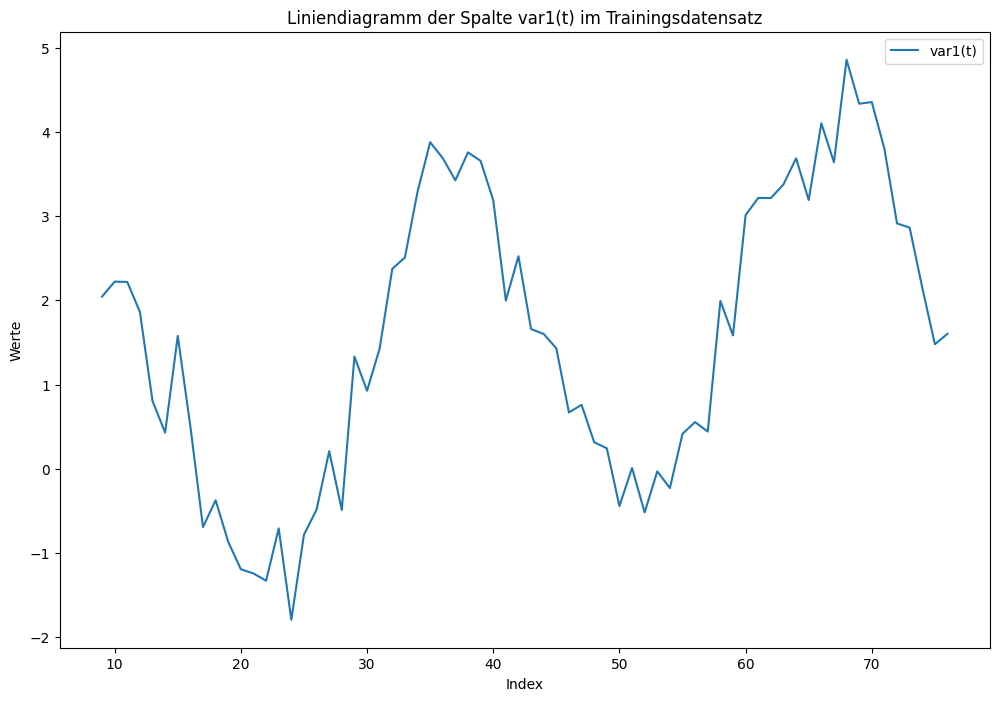

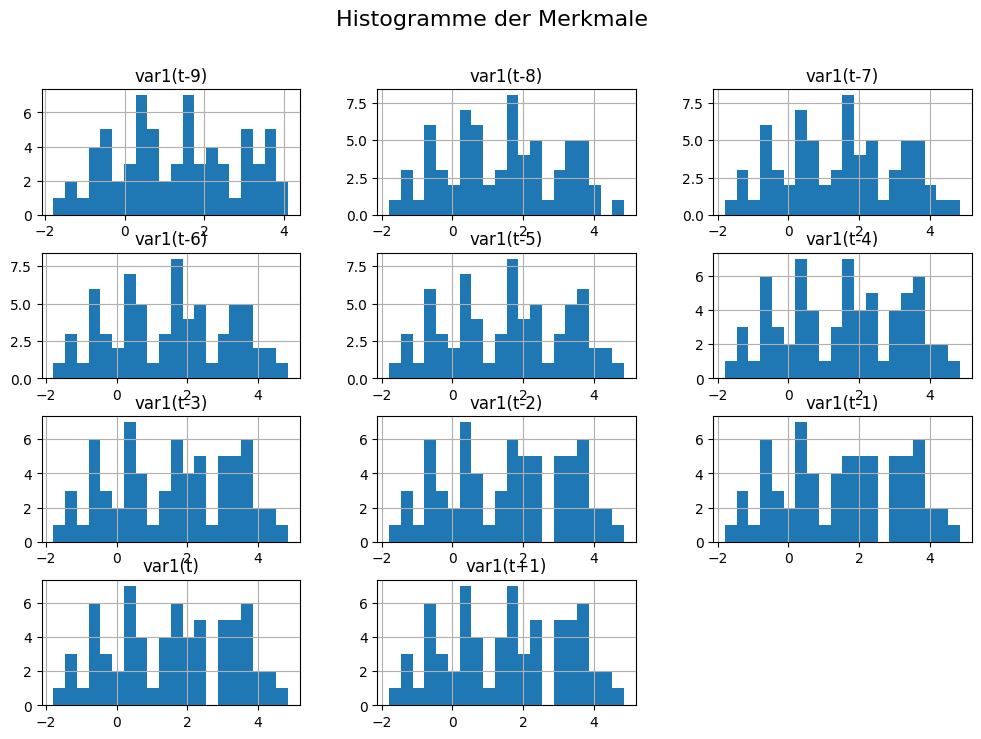

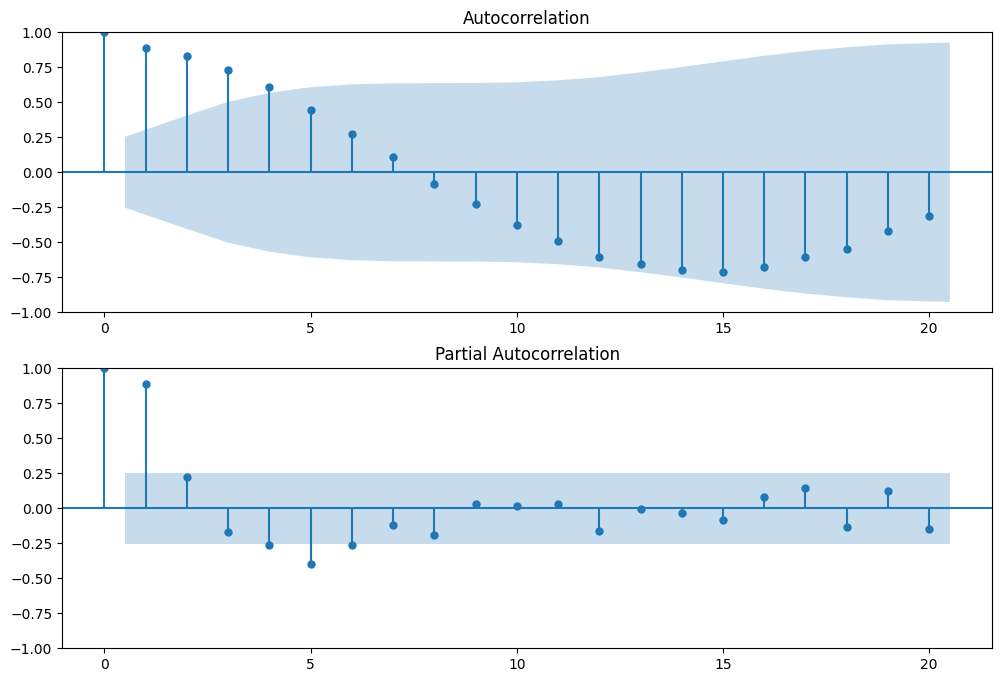


    Erklärung der ACF und PACF Plots:

    1. **Autokorrelationsfunktion (ACF)**:
    - Der ACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags.
    - Die höchste Autokorrelation beträgt 1.00.
    - Signifikante Autokorrelationen wurden bei den folgenden Lags gefunden: [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20].

    2. **Partielle Autokorrelationsfunktion (PACF)**:
    - Der PACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags, wobei der Einfluss der zwischenliegenden Lags entfernt wird.
    - Die höchste partielle Autokorrelation beträgt 1.35.
    - Signifikante partielle Autokorrelationen wurden bei den folgenden Lags gefunden: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20].

    Diese Plots sind besonders nützlich bei der Identifizierung der Ordnung von ARIMA-Modellen (AutoRegressive Integrated Moving Average).
    


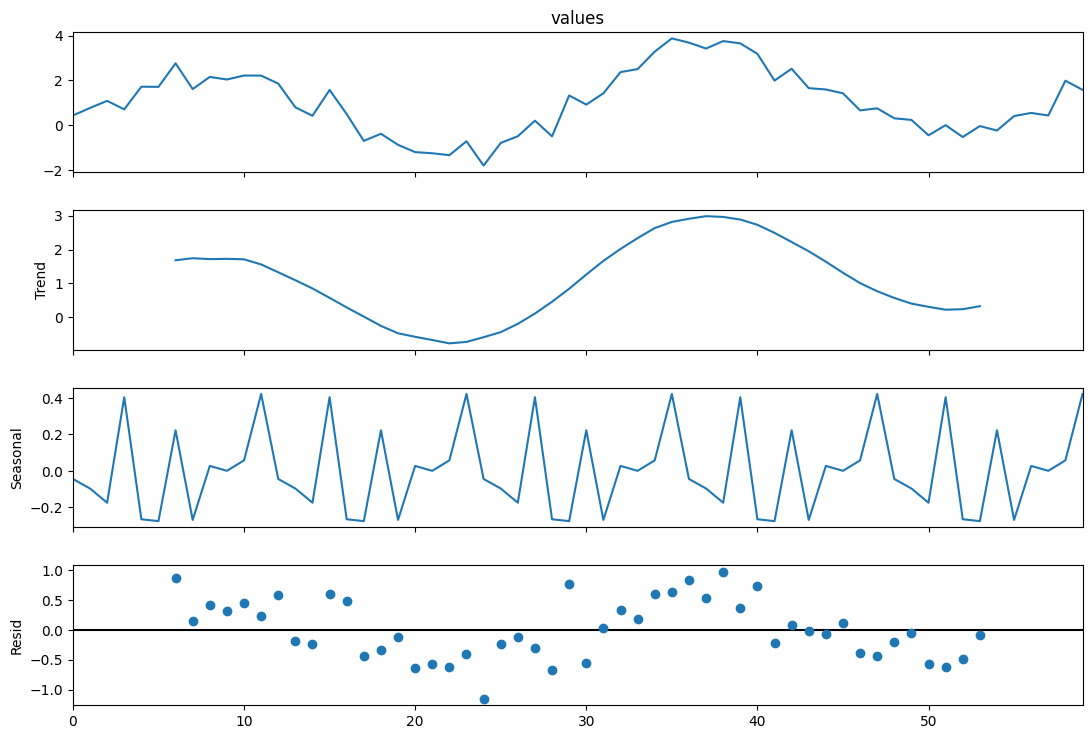


    Die Zeitreihe wurde in ihre Bestandteile zerlegt: Trend, Saisonalität und Residuen.

    1. **Trend**: Dieser zeigt die langfristige Bewegung in der Zeitreihe.
    - Der Mittelwert des Trends beträgt 1.08.
    - Der Trend reicht von einem Minimum von -0.77 bis zu einem Maximum von 2.98.

    2. **Saisonalität**: Dieser Teil zeigt wiederkehrende Muster in der Zeitreihe, die sich regelmäßig wiederholen.
    - Der Mittelwert der Saisonalität beträgt -0.00.
    - Die Saisonalität reicht von einem Minimum von -0.28 bis zu einem Maximum von 0.42.
    - Die Periode der Saisonalität wurde auf 12 gesetzt, was auf monatliche Daten hindeutet.

    3. **Residuen**: Diese repräsentieren die Zufallskomponente der Zeitreihe, die nicht durch Trend oder Saisonalität erklärt wird.
    - Der Mittelwert der Residuen beträgt 0.01.
    - Die Residuen reichen von einem Minimum von -1.16 bis zu einem Maximum von 0.97.

    Die Zerlegung der Zeitreihe hilft uns, die zugrunde liegenden Muster besser zu ver

In [27]:
#Lininen Diagramm
def plot_line_chart(train_df):
    column_name = "var1(t)"
    plt.figure(figsize=(12, 8))
    plt.plot(train_df[column_name], label=column_name)
    plt.title(f'Liniendiagramm der Spalte {column_name} im Trainingsdatensatz')
    plt.xlabel('Index')
    plt.ylabel('Werte')
    plt.legend()
    plt.show()

# Histogramm
def plot_histograms(data_train):
    data_train.hist(figsize=(12, 8), bins=20)
    plt.suptitle('Histogramme der Merkmale', fontsize=16)
    plt.show()

# Paarweise Plots
def plot_pairplots(data_train):
    sns.pairplot(data_train)
    plt.suptitle('Paarweise Plots der Merkmale', fontsize=16)
    plt.show()

# Autocorrelation und Partical Autocorrelation
def plot_acf_and_pacf(train_df):
    values = train_df['values']
    
    # ACF und PACF Werte berechnen
    acf_values = sm.tsa.acf(values, nlags=20)
    pacf_values = sm.tsa.pacf(values, nlags=20)
    
    # ACF und PACF plotten
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(values, lags=20, ax=ax[0])
    sm.graphics.tsa.plot_pacf(values, lags=20, ax=ax[1])
    plt.show()
    
    # Berechnung der dynamischen Erklärungsbestandteile
    significant_acf_lags = np.where(np.abs(acf_values) > 0.2)[0]  # Beispielhaftes Kriterium für Signifikanz
    significant_pacf_lags = np.where(np.abs(pacf_values) > 0.2)[0]
    
    max_acf = np.max(acf_values)
    max_pacf = np.max(pacf_values)
    
    explanation = f"""
    Erklärung der ACF und PACF Plots:

    1. **Autokorrelationsfunktion (ACF)**:
    - Der ACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags.
    - Die höchste Autokorrelation beträgt {max_acf:.2f}.
    - Signifikante Autokorrelationen wurden bei den folgenden Lags gefunden: {significant_acf_lags}.

    2. **Partielle Autokorrelationsfunktion (PACF)**:
    - Der PACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags, wobei der Einfluss der zwischenliegenden Lags entfernt wird.
    - Die höchste partielle Autokorrelation beträgt {max_pacf:.2f}.
    - Signifikante partielle Autokorrelationen wurden bei den folgenden Lags gefunden: {significant_pacf_lags}.

    Diese Plots sind besonders nützlich bei der Identifizierung der Ordnung von ARIMA-Modellen (AutoRegressive Integrated Moving Average).
    """
    print(explanation)

# Trend und Saisonalität
def plot_trend_and_season(train_df):
    values = train_df['values']
    decomposition = sm.tsa.seasonal_decompose(values, model='additive', period=12)
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.show()
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    resid = decomposition.resid.dropna()

    explanation = f"""
    Die Zeitreihe wurde in ihre Bestandteile zerlegt: Trend, Saisonalität und Residuen.

    1. **Trend**: Dieser zeigt die langfristige Bewegung in der Zeitreihe.
    - Der Mittelwert des Trends beträgt {trend.mean():.2f}.
    - Der Trend reicht von einem Minimum von {trend.min():.2f} bis zu einem Maximum von {trend.max():.2f}.

    2. **Saisonalität**: Dieser Teil zeigt wiederkehrende Muster in der Zeitreihe, die sich regelmäßig wiederholen.
    - Der Mittelwert der Saisonalität beträgt {seasonal.mean():.2f}.
    - Die Saisonalität reicht von einem Minimum von {seasonal.min():.2f} bis zu einem Maximum von {seasonal.max():.2f}.
    - Die Periode der Saisonalität wurde auf 12 gesetzt, was auf monatliche Daten hindeutet.

    3. **Residuen**: Diese repräsentieren die Zufallskomponente der Zeitreihe, die nicht durch Trend oder Saisonalität erklärt wird.
    - Der Mittelwert der Residuen beträgt {resid.mean():.2f}.
    - Die Residuen reichen von einem Minimum von {resid.min():.2f} bis zu einem Maximum von {resid.max():.2f}.

    Die Zerlegung der Zeitreihe hilft uns, die zugrunde liegenden Muster besser zu verstehen und ermöglicht es uns, Vorhersagemodelle genauer zu erstellen.
    """
    print(explanation)


# Aufrufen der Plot-Funktionen
plot_line_chart(data_train)
plot_histograms(data_train)
#plot_pairplots(data_train)
plot_acf_and_pacf(train_df)
plot_trend_and_season(train_df)




In [28]:
X_testRFR

,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
77,4.8559,4.3337,4.3532,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046
78,4.3337,4.3532,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454
79,4.3532,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161
80,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369
81,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324
82,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486
83,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464
84,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615
85,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361
86,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425


Mean Squared Error: 0.6719462137159167


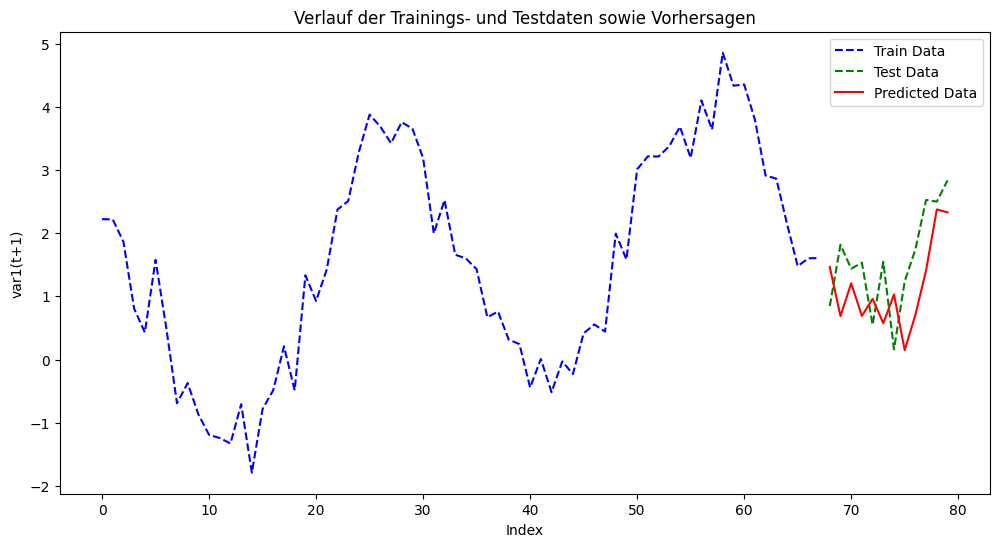

In [29]:
# Random Forest Regressor erstellen und trainieren
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_trainRFR, y_trainRFR)

# Vorhersagen auf den Testdaten
y_pred = model.predict(X_testRFR)

# Modellleistung evaluieren
mse = mean_squared_error(y_testRFR, y_pred)
print(f'Mean Squared Error: {mse}')

# Modell und Leistung ausgeben
model, mse

# Visualisierung der Daten
plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.plot(np.arange(len(y_trainRFR)), y_trainRFR, label='Train Data', color='blue', linestyle='--')

# Testdaten plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_testRFR, label='Test Data', color='green', linestyle='--')

# Vorhergesagte Werte plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_pred, label='Predicted Data', color='red')

plt.xlabel('Index')
plt.ylabel('var1(t+1)')
plt.title('Verlauf der Trainings- und Testdaten sowie Vorhersagen')
plt.legend()
plt.show()

In [30]:
CNN_model = cnn_initial(data_train)
CNN_model

In [31]:
import shap

In [32]:
feature_names_ = X_trainRFR.columns
feature_names_

Index(['var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)'],
      dtype='object')

In [33]:
tsl.iloc[:,:]

,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1)
9,0.4414,0.7764,1.0921,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216
10,0.7764,1.0921,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176
11,1.0921,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176,1.8625
12,0.7132,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176,1.8625,0.8038
13,1.7238,1.7171,2.7643,1.6173,2.1594,2.0445,2.2216,2.2176,1.8625,0.8038,0.4292
...,...,...,...,...,...,...,...,...,...,...,...
84,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361
85,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425
86,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425,2.5263
87,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425,2.5263,2.4987


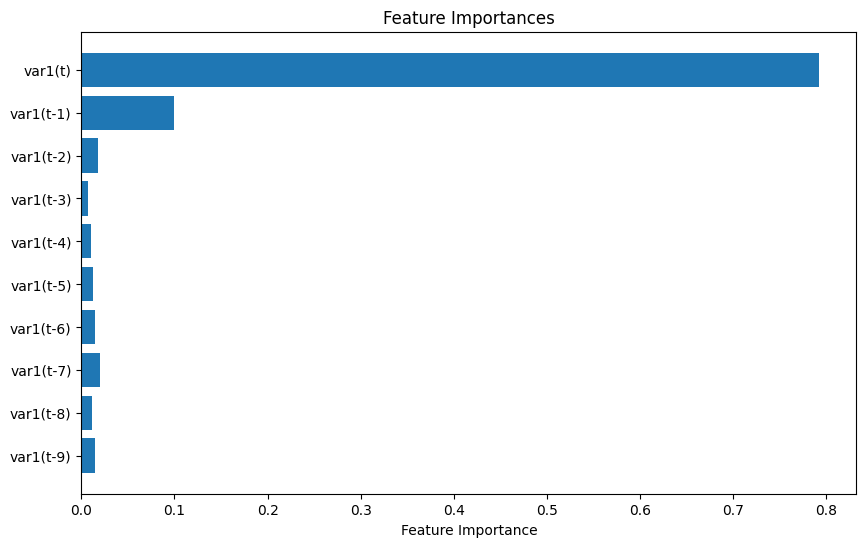

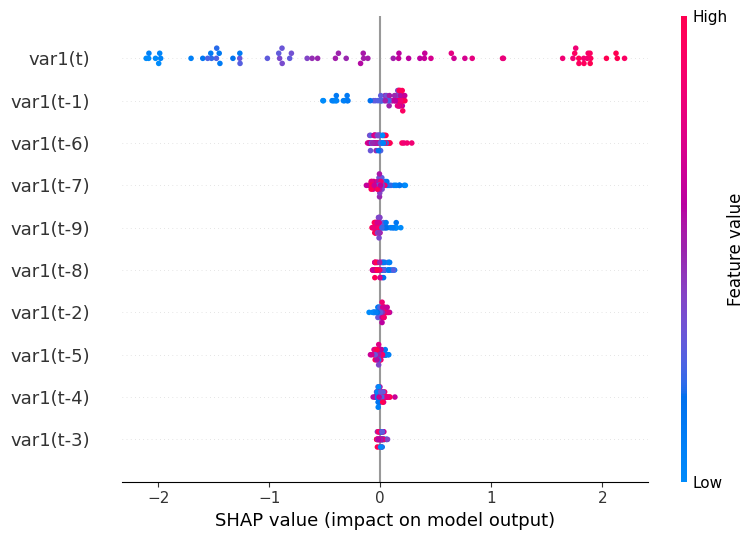

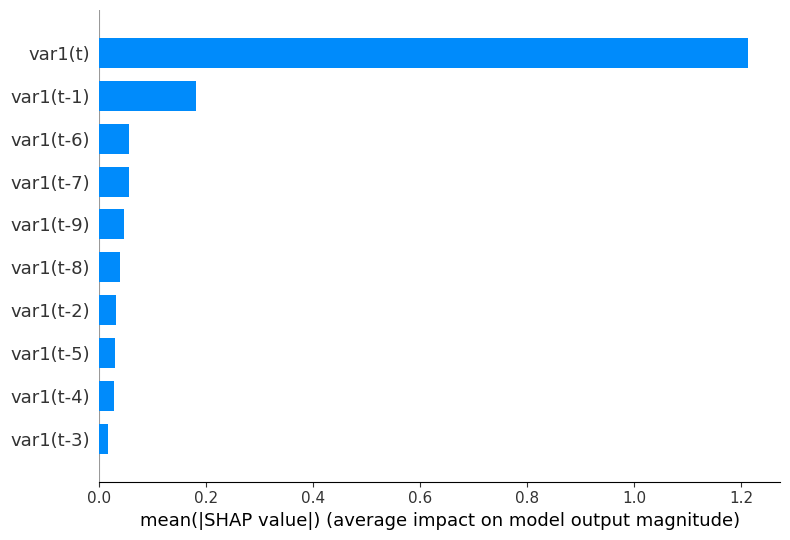

In [34]:
# Feature Importance berechnen und plotten
importances = model.feature_importances_
feature_names = ['var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)']
feature_names_ = X_trainRFR.columns



plt.figure(figsize=(10, 6))
plt.barh(feature_names_, importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

# SHAP Werte berechnen
explainer = shap.TreeExplainer(model)
#explainer = shap.Explainer(CNN_model)
#explainer_CNN = shap.DeepExplainer(CNN_model)
shap_values = explainer.shap_values(X_trainRFR)
shap_values = explainer(X_trainRFR)

shap.summary_plot(shap_values, X_trainRFR, feature_names=feature_names_)
shap.summary_plot(shap_values, X_trainRFR, feature_names=feature_names_, plot_type='bar')

In [56]:
shap_values[0]  # access all shap values for all features for one instance. The sum of that would be the prediction shift
shap_values.values.sum(axis=0) # Aggregating all shapley values for the individual features. 

array([ 0.23337895,  0.55575158,  0.09426039, -0.19751467, -0.54263469,
        0.33626423,  0.36343241,  0.5132585 ,  1.82543011, -3.42738082])

In [66]:
shap_values.values[0].round(4)

array([ 0.0289,  0.0384,  0.0076, -0.012 , -0.0153, -0.0032, -0.0164,
        0.0079,  0.1689,  0.3565])

In [57]:
tsl.columns[0]

'var1(t-9)'

In [63]:
tsl.columns

Index(['var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)',
       'var1(t+1)'],
      dtype='object')

In [58]:
shap_values.values[:,0] # getting all shapley values for feature [,x] 0--> t-9

array([ 0.02891135, -0.01012556, -0.01108001, -0.01649676, -0.04634493,
       -0.0249909 , -0.06646725, -0.05134091, -0.04244508, -0.03617584,
       -0.02830839, -0.0293584 , -0.02800275, -0.00330362, -0.05744464,
       -0.01397538, -0.00869378,  0.11510562,  0.02488114,  0.14383805,
        0.12910963,  0.13782765,  0.18475976,  0.10035406,  0.14599812,
        0.09110377,  0.05198682, -0.00320486,  0.06286039, -0.01418689,
       -0.01488873, -0.0164006 , -0.00970576, -0.03797633, -0.04762896,
       -0.04728555, -0.07476571, -0.04463028, -0.06321397, -0.05473665,
       -0.05391994, -0.03735392, -0.04743941, -0.031065  , -0.02234367,
       -0.01540282, -0.01117761, -0.02478007,  0.11655761,  0.04001179,
        0.14351209,  0.02956377,  0.04686998,  0.01412496,  0.05142531,
       -0.0178566 ,  0.00970212, -0.00312829, -0.0003307 , -0.00188998,
       -0.00636622, -0.01702246, -0.0264262 , -0.03510953, -0.04414156,
       -0.03937307, -0.04885691, -0.04796256])

In [60]:
np.mean(np.abs(shap_values.values[:,-1]))  ####<--- aggregating the absolut sum of them, shows the absolute impact of feature t_0

1.2114065272925552

In [61]:
X_testRFR

,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
77,4.8559,4.3337,4.3532,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046
78,4.3337,4.3532,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454
79,4.3532,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161
80,3.7981,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369
81,2.9119,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324
82,2.8630,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486
83,2.1508,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464
84,1.4784,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615
85,1.6022,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361
86,1.6046,0.8454,1.8161,1.4369,1.5324,0.5486,1.5464,0.1615,1.2361,1.7425


In [62]:
y_pred

array([1.464339, 0.686451, 1.205667, 0.688919, 0.96136 , 0.574837,
       1.030057, 0.147976, 0.706868, 1.411684, 2.375196, 2.329073])

In [41]:
temporary_dict = {"time":[],"top":[], "bottom":[], "color":[], "value":[]}
temporary_dict["time"] =  X_testRFR.index
for i,v in enumerate(shap_values_test.values):
    print(v.sum())
    curr_val = y_pred[i]
    if v.sum() < 0:
        temporary_dict["top"].append(curr_val)
        temporary_dict["color"].append("#00099")
        temporary_dict["bottom"].append(curr_val + v.sum())
    else:
        temporary_dict["top"].append(curr_val+v.sum())
        temporary_dict["color"].append("#990000")
        temporary_dict["bottom"].append(curr_val)

temporary_dict

NameError: name 'shap_values_test' is not defined

In [54]:
shap_values_test = explainer(X_testRFR)
shap_values_test.values.sum(axis=1)
    

array([-0.09508891, -0.87297691, -0.35376091, -0.87050891, -0.59806791,
       -0.98459091, -0.52937091, -1.41145191, -0.85255991, -0.14774391,
        0.81576809,  0.76964509])

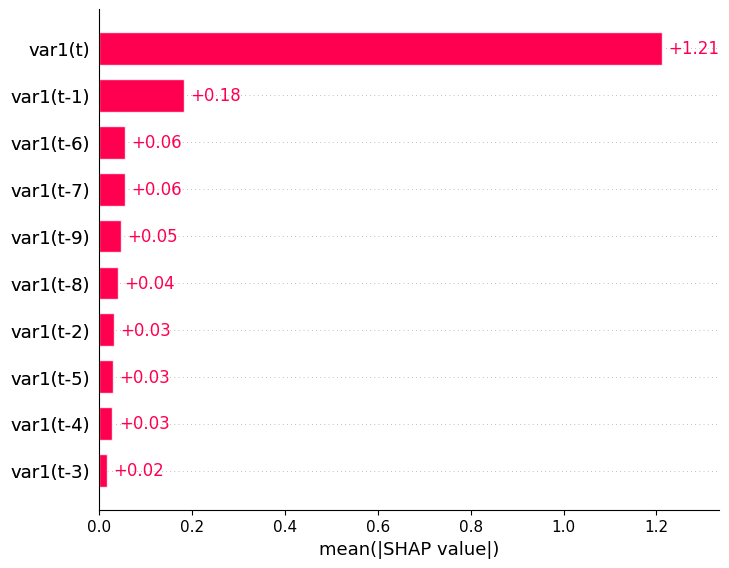

In [55]:
shap.plots.bar(shap_values)
# shows mean of the shapley values whichs is =/= feature importance


array([ 0.23337895,  0.55575158,  0.09426039, -0.19751467, -0.54263469,
        0.33626423,  0.36343241,  0.5132585 ,  1.82543011, -3.42738082])

Erklärungen zu den Visualisierungen:

Dependence Plots: Diese Plots zeigen, wie sich der SHAP-Wert eines Features mit dem Wert des Features ändert. Dies hilft, die Beziehung zwischen einem Feature und der Zielvariable besser zu verstehen.


Force Plots: Diese Plots zeigen die Vorhersage für ein einzelnes Beispiel und wie die Features zu dieser Vorhersage beitragen. Jeder Balken repräsentiert den Einfluss eines Features auf die Vorhersage.

In [ ]:
shap_values[0]

.values =
array([ 0.03438279, -0.00697227,  0.00860516,  0.01670381,  0.00978899,
        0.00310136, -0.02726738, -0.03799538,  0.10683088,  0.43812155])

.base_values =
1.5493075

.data =
array([-0.0653,  1.4495,  0.6078,  0.3845,  1.1972,  2.3865,  3.0007,
        2.1826,  2.5884,  2.1597])

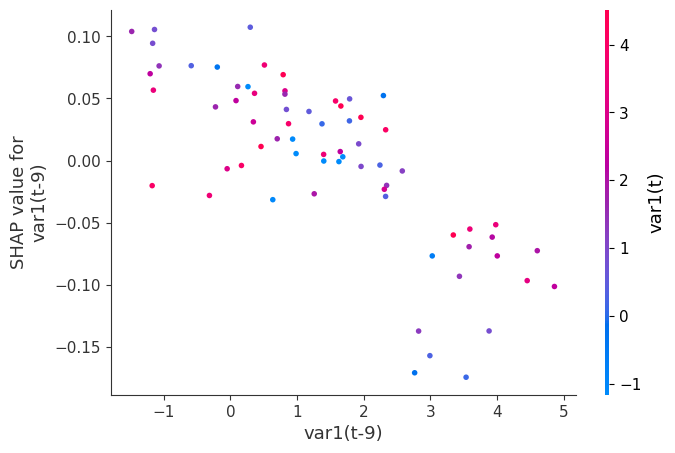

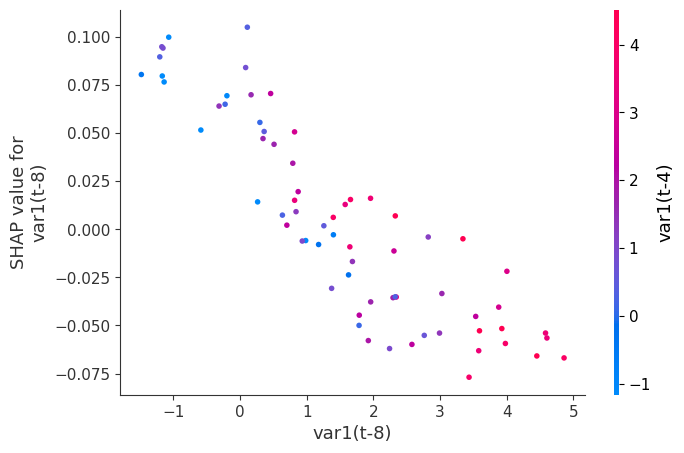

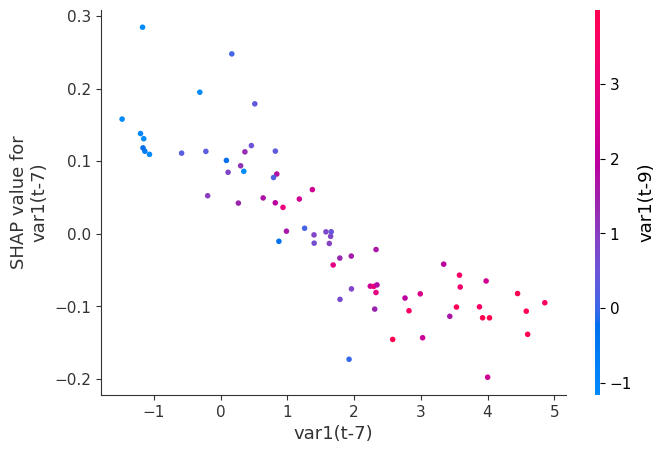

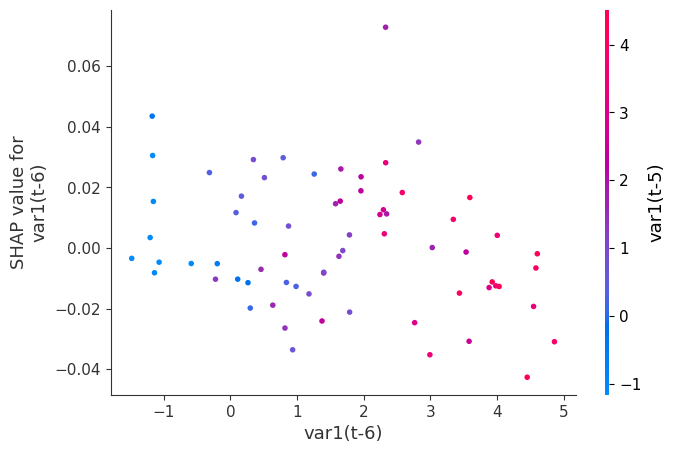

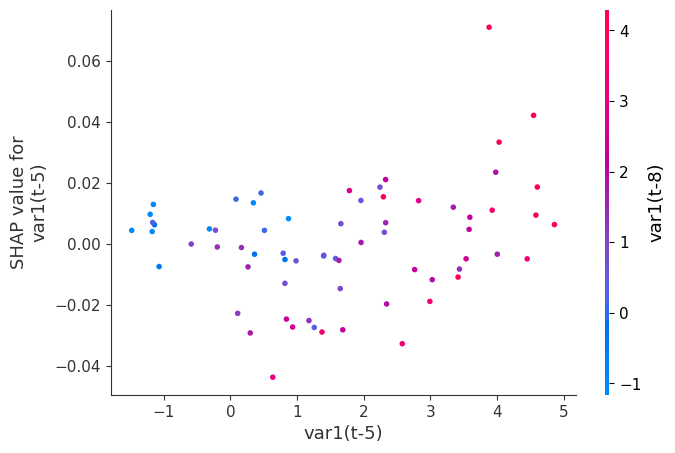

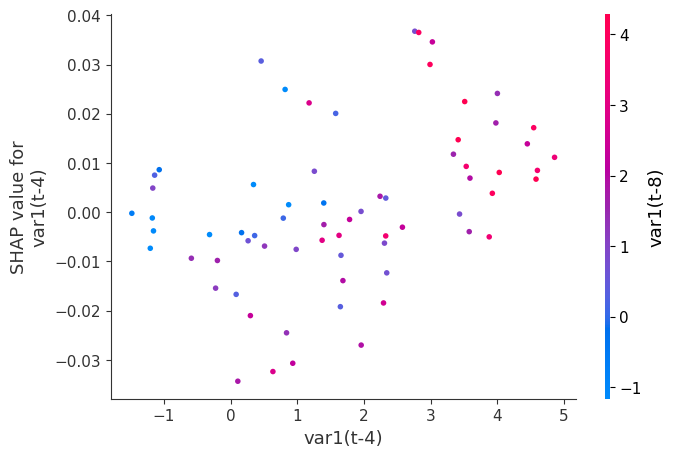

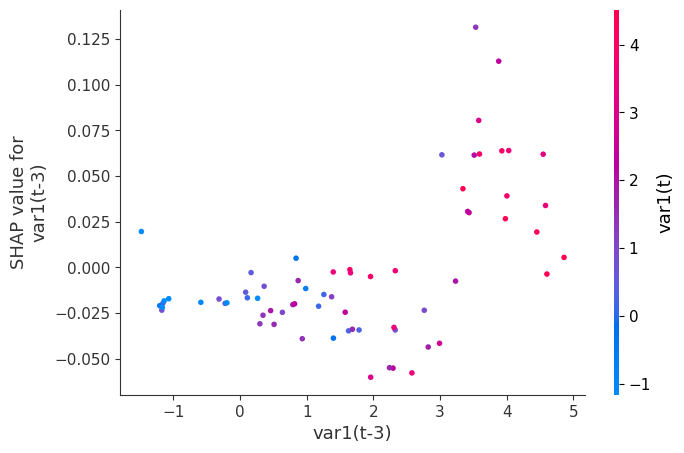

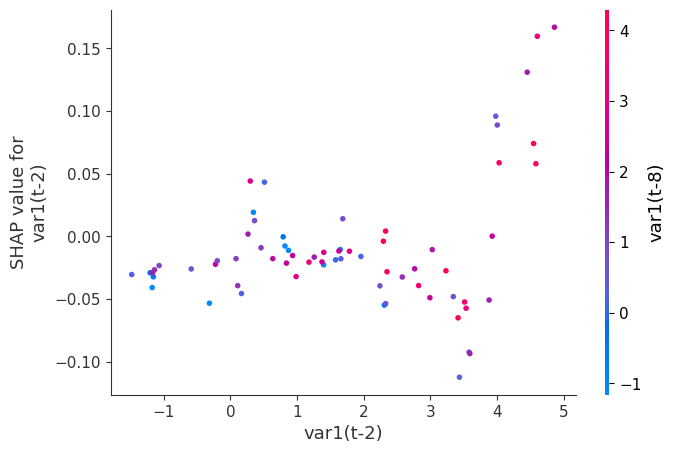

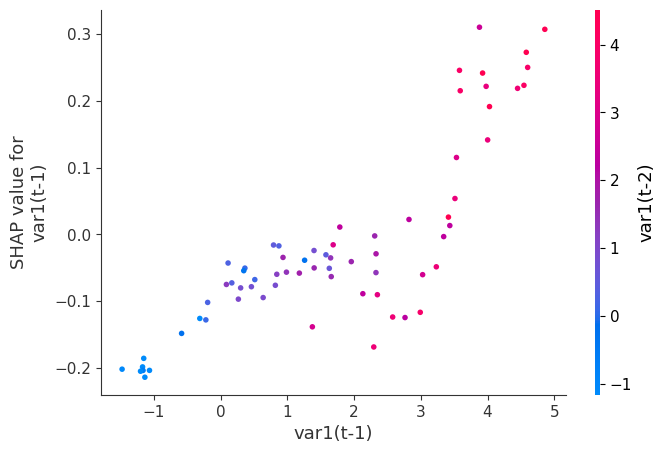

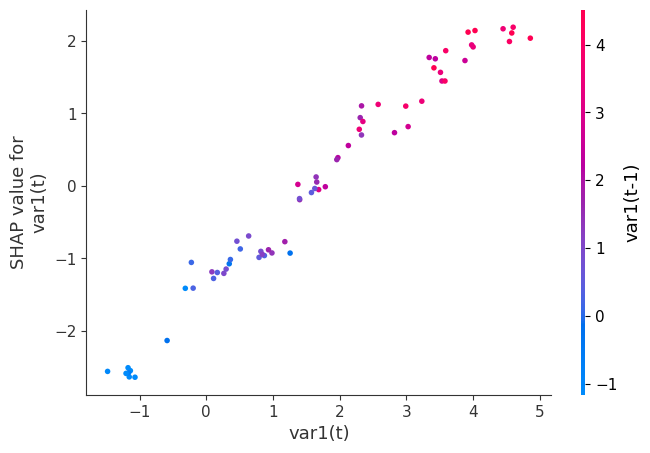

In [ ]:
# Abhängigkeits-Plots (Dependence Plots) erstellen
for feature_name in X_trainRFR.columns:
    shap.dependence_plot(feature_name, shap_values, X_trainRFR, feature_names=X_trainRFR.columns)

# Verteilung der SHAP-Werte für ein Beispiel
shap.initjs()
sample_index = 0  # Index des Beispiels, das wir visualisieren möchten
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_trainRFR.iloc[sample_index], feature_names=X_trainRFR.columns)


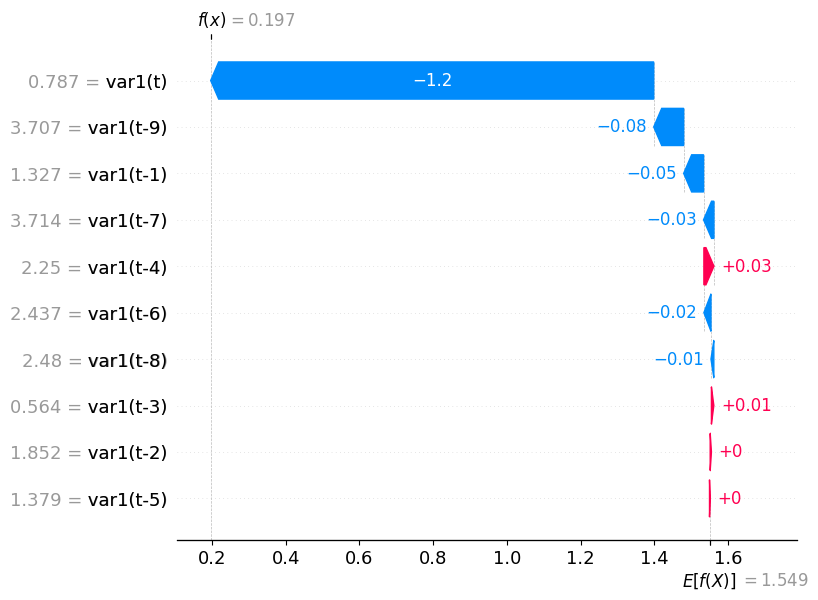

In [ ]:
# SHAP Werte berechnen
#explainer = shap.Explainer(model, X_trainRFR)
#explainer = shap.TreeExplainer(model)
shap_values_expl = explainer(X_testRFR)

# Waterfall Diagramm für eine einzelne Vorhersage (z.B. die erste)
shap.waterfall_plot(shap_values_expl[4])

In [ ]:
shap_values[4]

.values =
array([-0.0158153 , -0.01591109,  0.00204285, -0.00427063, -0.01341887,
        0.04183131,  0.04819596,  0.00357833,  0.02888426, -0.88799532])

.base_values =
1.5493075

.data =
array([1.1972, 2.3865, 3.0007, 2.1826, 2.5884, 2.1597, 2.2407, 1.9516,
       2.0189, 0.8959])

In [ ]:
shap_values_expl[4]

.values =
array([-0.08122401, -0.00773088, -0.02812476, -0.01923866,  0.00185319,
        0.02723983,  0.00652469,  0.00334033, -0.0539487 , -1.20137852])

.base_values =
1.5493075

.data =
array([3.7068, 2.4798, 3.7139, 2.4368, 1.379 , 2.25  , 0.5642, 1.8523,
       1.3274, 0.7865])

Feature-Importance und SHAP-Werte
Feature-Importance in Random Forest:

Random Forest ist ein Ensemble-Lernalgorithmus, der mehrere Entscheidungsbäume kombiniert. Jeder Baum trifft Vorhersagen basierend auf verschiedenen Features, und die durchschnittliche Reduktion des Fehlers, wenn ein Feature in den Bäumen verwendet wird, gibt an, wie wichtig dieses Feature ist.
Die Feature-Importance, die von Random Forest zurückgegeben wird, misst den durchschnittlichen Beitrag eines Features zur Vorhersage über alle Bäume hinweg.
SHAP-Werte:

SHAP (SHapley Additive exPlanations) ist eine Methode zur Erklärung der Vorhersagen von Machine-Learning-Modellen. SHAP-Werte messen den Beitrag jedes Features zur Differenz zwischen der Vorhersage und dem durchschnittlichen Modelloutput.
Ein höherer absoluter SHAP-Wert für ein Feature bedeutet, dass das Feature einen größeren Einfluss auf die Vorhersage hat.
Grund für den großen Einfluss von var1(t)
Zeitliche Nähe:

var1(t) repräsentiert den Wert des betrachteten Parameters zur aktuellen Zeit t. Bei zeitlich sequenziellen Daten (wie Zeitreihen) haben die jüngsten Werte oft den größten Einfluss auf zukünftige Werte. Dies liegt daran, dass nahe Werte tendenziell mehr Informationen über den aktuellen Zustand und damit über zukünftige Zustände liefern.
Autokorrelation:

In vielen Zeitreihen gibt es eine hohe Autokorrelation, das heißt, dass die Werte zu einem bestimmten Zeitpunkt stark mit den Werten zu vorherigen Zeitpunkten korrelieren. Dies bedeutet, dass var1(t) in der Regel eine gute Vorhersage für var1(t+1) ist.

FAZIT

Der große Einfluss von var1(t) auf die Vorhersage kann durch die zeitliche Nähe und die Autokorrelation in den Daten erklärt werden. var1(t) enthält die aktuellsten Informationen und ist daher oft der wichtigste Prädiktor für den nächsten Zeitpunkt t+1. Die SHAP-Werte bieten eine detaillierte Erklärung für den Beitrag jedes Features zur Modellvorhersage.

In [ ]:
y_pred

array([1.322405, 0.5453  , 1.323698, 0.524551, 0.361629, 0.089393,
       0.567133, 0.662542, 0.706656, 2.103603, 1.393176, 2.519064])

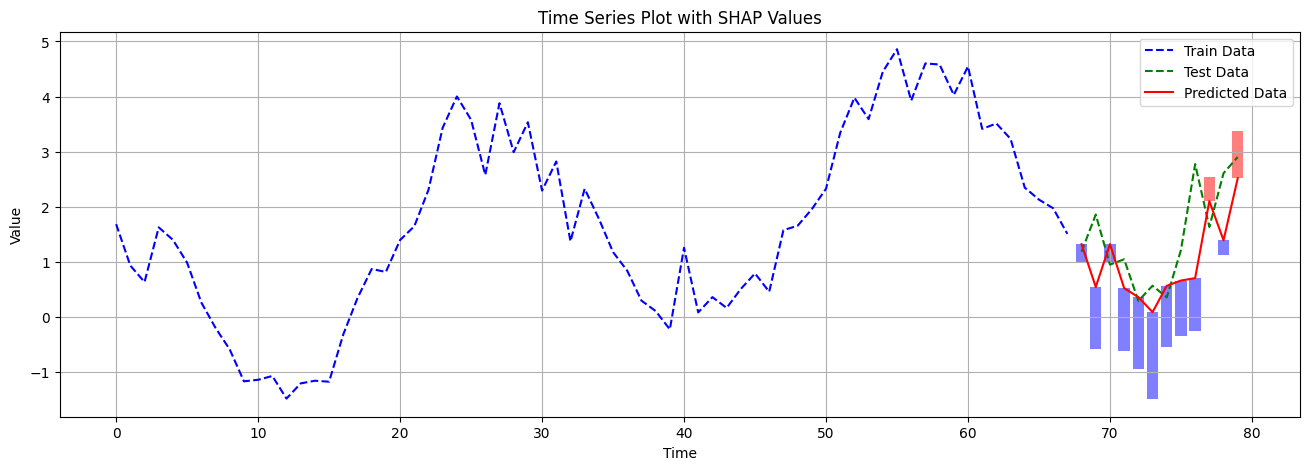

In [ ]:

# Plotten der tatsächlichen und vorhergesagten Zeitreihe
# Trainingsdaten plotten
plt.figure(figsize=(16,5))
plt.grid()
plt.plot(np.arange(len(y_trainRFR)), y_trainRFR, label='Train Data', color='blue', linestyle='--')

# Testdaten plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_testRFR, label='Test Data', color='green', linestyle='--')

# Vorhergesagte Werte plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_pred, label='Predicted Data', color='red')


# Hinzufügen der SHAP-Werte als Balken
for i in range(len(y_pred)):
    shap_sum = shap_values_expl[i].values.sum()  # Summe der SHAP-Werte für eine Vorhersage
    plt.bar(i + len(y_trainRFR), shap_sum, bottom=y_pred[i], color="red" if shap_sum > 0 else "blue", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Plot with SHAP Values")

plt.show()



In [ ]:
shap_values.values

NameError: name 'shap_values' is not defined

In [ ]:
shap_values

.values =
array([[-2.44047437e-02, -1.17223985e-02, -8.53137098e-03,
         6.04360961e-03, -2.11100819e-02, -3.90655428e-02,
         1.86915194e-03,  1.23995100e-03, -3.27987856e-02,
         6.20466049e-01],
       [-3.11395941e-02, -1.97873440e-02, -1.10362160e-02,
         2.58260240e-03, -2.39546870e-02, -4.31465243e-02,
        -1.70427915e-02, -2.81166338e-02, -3.27538936e-02,
         5.90601920e-01],
       [-4.11086933e-02, -1.43780719e-02, -1.47599778e-02,
         1.65673228e-02, -2.02668433e-02,  5.86432848e-03,
         6.22679304e-04, -1.59925911e-03, -4.33352179e-02,
         6.55773571e-01],
       [-6.43673925e-02, -4.70804554e-02, -4.18882496e-02,
         9.44391641e-04, -4.16644751e-02, -5.83307831e-02,
        -1.42490952e-03, -3.46684622e-02, -5.68296629e-02,
         5.29571837e-01],
       [-3.32225825e-02, -3.58188568e-02, -3.19212233e-02,
        -2.07712789e-02, -3.87007908e-02, -2.64594475e-02,
         3.11876163e-02, -2.27421341e-02,  1.97218830e-02,
 

In [ ]:
for s_v in shap_values.value

SyntaxError: expected ':' (2670383931.py, line 1)

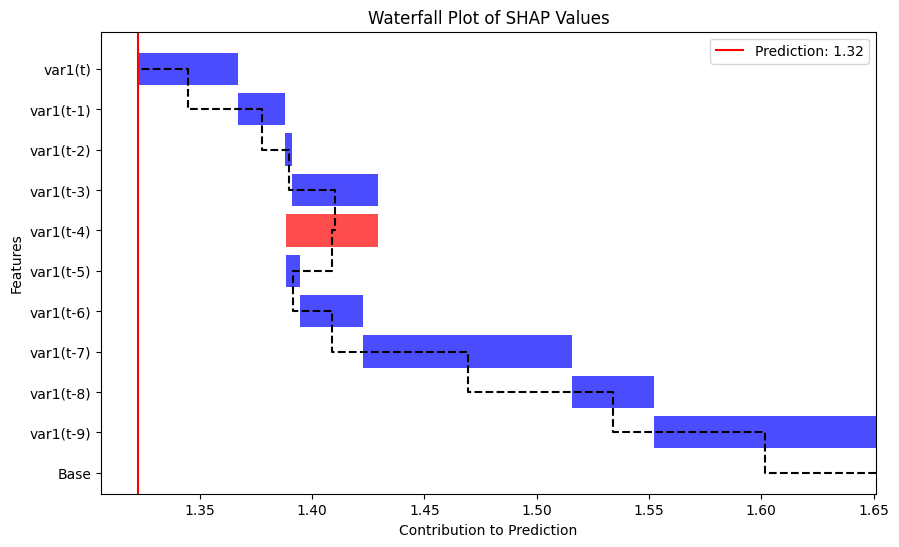

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Beispielwerte (ersetzen Sie diese durch Ihre tatsächlichen SHAP-Werte und Basisvorhersage)
base_value = np.mean(y_pred)  # Basisvorhersage (z.B. Mittelwert der Zielvariable)
base_value = shap_values[0].base_values

# Annahme: shap_values ist eine Liste von shap.Explanation-Objekten
# Hier extrahieren wir die SHAP-Werte für das erste Beispiel
shap_values_example = shap_values[0].values
feature_names = shap_values[0].feature_names  # Annahme: Feature-Namen sind in den SHAP-Werten enthalten

# Kumulative Summe der Basisvorhersage und SHAP-Werte berechnen
cumulative_contributions = np.cumsum([base_value] + list(shap_values_example))

# Wasserfall-Plot erstellen
plt.figure(figsize=(10, 6))

# Balken zeichnen
for i in range(1, len(cumulative_contributions)):
    plt.barh(i, cumulative_contributions[i] - cumulative_contributions[i-1], 
             left=cumulative_contributions[i-1], 
             color='red' if shap_values_example[i-1] > 0 else 'blue', 
             alpha=0.7)

# Linie zeichnen
plt.step(cumulative_contributions, range(len(cumulative_contributions)), where='mid', color='k', linestyle='--')

# Beschriftungen hinzufügen
plt.yticks(range(len(cumulative_contributions)), ['Base'] + feature_names)
plt.ylabel('Features')
plt.xlabel('Contribution to Prediction')
plt.title('Waterfall Plot of SHAP Values')
plt.axvline(base_value + sum(shap_values_example), color='r', linestyle='-', label=f'Prediction: {base_value + sum(shap_values_example):.2f}')
plt.legend()
plt.show()

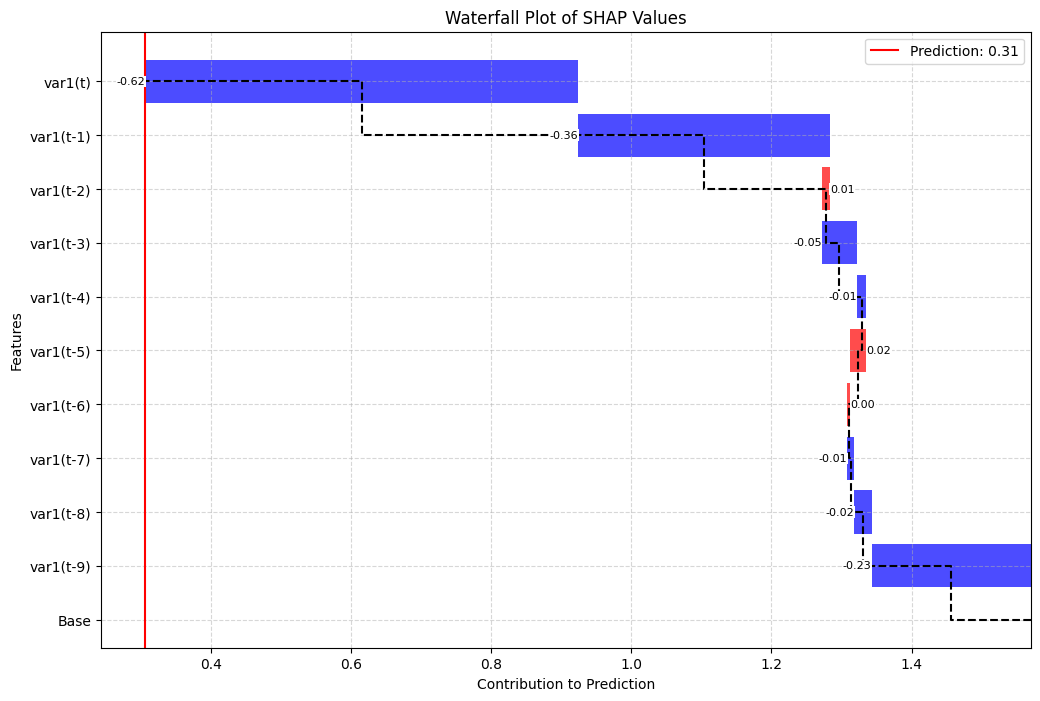

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the required data: y_pred and shap_values
# For example purposes, we will generate some mock data
np.random.seed(42)
y_pred = np.random.rand(100)  # Replace with your actual prediction values
base_value = shap_values[0].base_values

feature_names = shap_values[0].feature_names  # Annahme: Feature-Namen sind in den SHAP-Werten enthalten

# Mock shap_values for demonstration purposes
class MockShapValues:
    def __init__(self, values, base_values, feature_names):
        self.values = values
        self.base_values = base_values
        self.feature_names = feature_names

shap_values_example = shap_values[0].values
shap_values = [MockShapValues(shap_values_example, base_value, feature_names)]

# Extracting the necessary information from the SHAP values
base_value = shap_values[0].base_values
shap_values_example = shap_values[0].values
feature_names = shap_values[0].feature_names

# Calculating cumulative contributions
cumulative_contributions = np.cumsum([base_value] + list(shap_values_example))

# Creating the waterfall plot
plt.figure(figsize=(12, 8))

# Drawing bars
colors = ['red' if value > 0 else 'blue' for value in shap_values_example]
for i in range(1, len(cumulative_contributions)):
    plt.barh(i, cumulative_contributions[i] - cumulative_contributions[i-1], 
             left=cumulative_contributions[i-1], 
             color=colors[i-1], 
             alpha=0.7)

# Drawing lines
plt.step(cumulative_contributions, range(len(cumulative_contributions)), where='mid', color='k', linestyle='--')

# Adding text annotations
for i in range(1, len(cumulative_contributions)):
    plt.text(cumulative_contributions[i], i, f'{cumulative_contributions[i] - cumulative_contributions[i-1]:.2f}', 
             va='center', ha='left' if shap_values_example[i-1] > 0 else 'right', 
             color='black', fontsize=8, bbox=dict(facecolor='white', edgecolor='none', pad=0.5))

# Adding labels and title
plt.yticks(range(len(cumulative_contributions)), ['Base'] + feature_names)
plt.ylabel('Features')
plt.xlabel('Contribution to Prediction')
plt.title('Waterfall Plot of SHAP Values')
plt.axvline(base_value + sum(shap_values_example), color='r', linestyle='-', 
            label=f'Prediction: {base_value + sum(shap_values_example):.2f}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()
